First let's fit our supernova synthetic data from last time using GPR.

The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.\
But check out what's available in the kernels submodule of sklearn.gaussian_process.\
Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
Interpret the results.

Note. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

In [571]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [ ]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [ ]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_21224\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


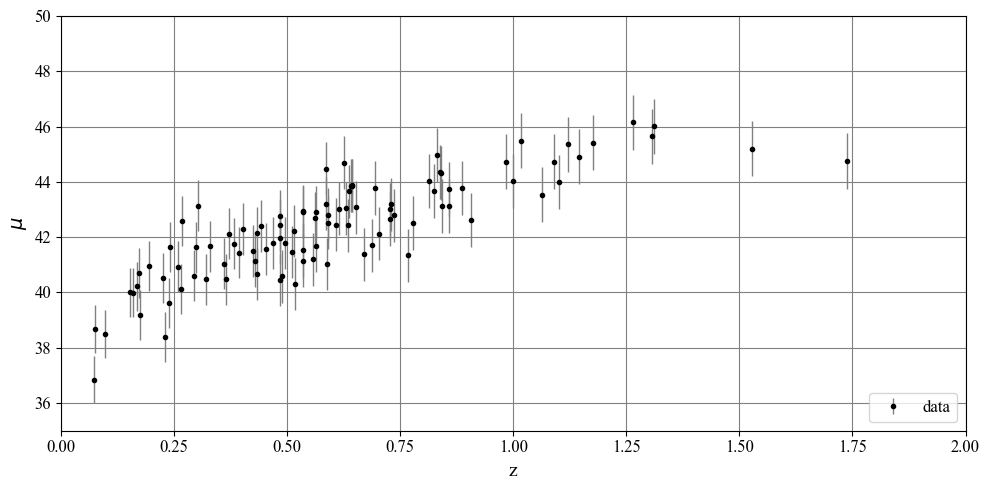

In [ ]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## GPR fit - RBF + Whiten

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = train_test_split(z_sample, mu_sample, dmu, test_size=0.2, random_state=42)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# These are your original scalers
z_scaler = StandardScaler().fit(z_sample.reshape(-1, 1))
mu_scaler = StandardScaler().fit(mu_sample.reshape(-1, 1))

In [ ]:
z_scaled = z_scaler.fit_transform(z_sample.reshape(-1, 1))
mu_scaled = mu_scaler.fit_transform(mu_sample.reshape(-1, 1))
z_train_scaled = z_scaler.fit_transform(z_train.reshape(-1, 1))
mu_train_scaled = mu_scaler.fit_transform(mu_train.reshape(-1, 1))
z_test_scaled = z_scaler.fit_transform(z_test.reshape(-1, 1))
mu_test_scaled = mu_scaler.fit_transform(mu_test.reshape(-1, 1))

In [ ]:
dmu_scaled = dmu / mu_scaler.scale_[0]
dmu_train_scaled = dmu_train / mu_scaler.scale_[0]

In [ ]:
K = kernels.RBF(length_scale=0.1) + kernels.WhiteKernel()

In [ ]:
GPR = GaussianProcessRegressor(kernel=K, alpha=dmu_train_scaled**2, n_restarts_optimizer=10, random_state=42)

In [ ]:
GPR.fit(z_train_scaled, mu_train_scaled)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=array([0.42538002, 0.40139305, 0.38552691, 0.34378601, 0.35910916,
       0.39657461, 0.34742171, 0.39497291, 0.42092733, 0.39064371,
       0.39260206, 0.39659022, 0.36334389, 0.37955206, 0.43195545,
       0.37592808, 0.38929549, 0.34577769, 0.40629746, 0.39274055,
       0.39273283, 0.40627453, 0.41381773, 0.39270583, 0.41271711,
       0.42168346, 0.39994705, 0.40258901, 0.39...
       0.44698041, 0.42377101, 0.41384118, 0.39122817, 0.41298474,
       0.36865782, 0.40639892, 0.42723507, 0.39702949, 0.40061265,
       0.39688751, 0.40016374, 0.38834677, 0.38348625, 0.41640003,
       0.39704999, 0.37202018, 0.40934972, 0.42623988, 0.38319784,
       0.37699679, 0.39829748, 0.3835904 , 0.39440247, 0.39961694]),
                         kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10, random_state=42)

In [ ]:
GPR.score(z_test_scaled, mu_test_scaled)

0.6353878858441135

In [ ]:
X_plot = np.linspace(z_train_scaled.min(), z_train_scaled.max(), 500)
mean, std = GPR.predict(X_plot.reshape(-1, 1), return_std=True)

(-3.0951937187192704, 2.1164384003766235)

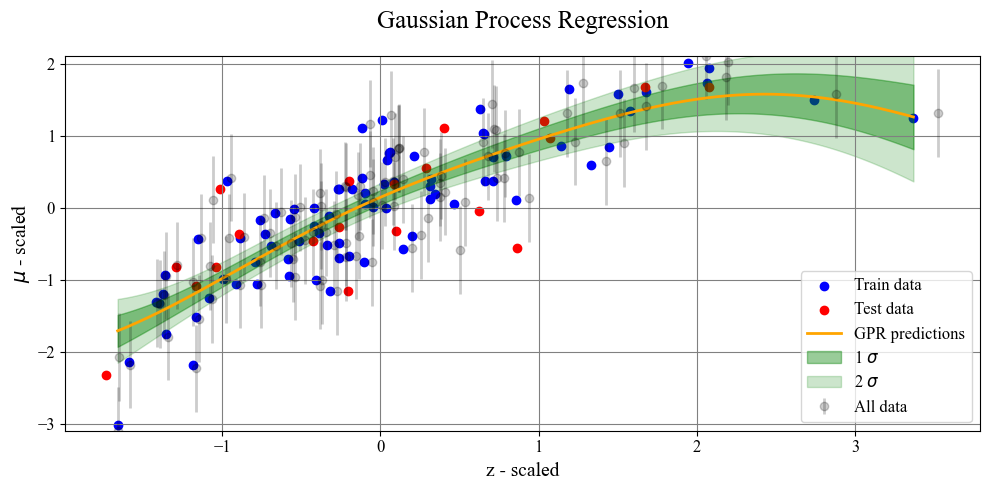

In [ ]:
plt.errorbar(z_scaled.T[0], mu_scaled.T[0], dmu_scaled.T[0],  fmt='o', c='black', label='All data', alpha=0.2)
plt.scatter(z_train_scaled, mu_train_scaled, c='blue', label='Train data')
plt.scatter(z_test_scaled, mu_test_scaled, c='red', label='Test data')
plt.plot(X_plot, mean, c='orange', label='GPR predictions')
plt.fill_between(X_plot.ravel(), mean - std, mean + std, alpha=0.4, color='green', label=r"1 $\sigma$")
plt.fill_between(X_plot.ravel(), mean - 2*std, mean + 2*std, alpha=0.2, color='green', label=r"2 $\sigma$")
plt.xlabel("z - scaled")
plt.ylabel(r"$\mu$ - scaled")
plt.legend(loc='lower right')
plt.title("Gaussian Process Regression")
plt.ylim(mu_scaled.min(),mu_scaled.max())


In [ ]:
print('log_likelihood:' ,GPR.log_marginal_likelihood())

log_likelihood: -71.0752310046213


Kernel is good! Now we can cross validate on noise level and scale length

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
from itertools import product

In [ ]:
length_scales = [0.01, 0.05, 0.1, 0.5, 1]
noise_levels = [1e-5, 1e-3, 1e-1, 1.0]

kernel_grid = [
    kernels.RBF(length_scale=l) + kernels.WhiteKernel(noise_level=n)
    for l, n in product(length_scales, noise_levels)
]

In [ ]:
X = z_train_scaled.reshape(-1, 1)
y = mu_train_scaled

results = []
for kernel in kernel_grid:
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)  # Disable internal optimization
    score = cross_val_score(gpr, X, y, cv=kf, scoring='neg_mean_squared_error')
    results.append((kernel, score.mean()))

In [ ]:
best_kernel, best_score = max(results, key=lambda x: x[1])
print(f"Best kernel: {best_kernel}")
print(f"Best CV score: {best_score}")

Best kernel: RBF(length_scale=1) + WhiteKernel(noise_level=0.1)
Best CV score: -0.27781829801457325


In [ ]:
GPR = GaussianProcessRegressor(kernel=best_kernel, alpha=dmu_scaled**2, n_restarts_optimizer=10, random_state=42)
GPR.fit(z_scaled, mu_scaled)
X_plot = np.linspace(z_scaled.min(), z_scaled.max(), 500)
mean, std = GPR.predict(X_plot.reshape(-1, 1), return_std=True)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
X_plot = np.linspace(z_scaled.min(), z_scaled.max(), 500)
mean, std = GPR.predict(X_plot.reshape(-1, 1), return_std=True)

Text(0.5, 1.0, 'Gaussian Process Regression')

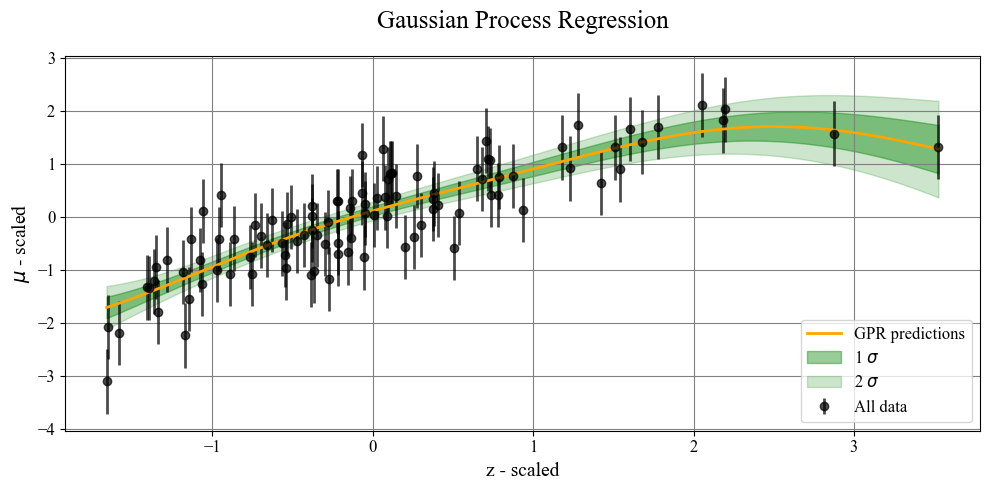

In [ ]:
plt.errorbar(z_scaled.T[0], mu_scaled.T[0], dmu_scaled.T[0],  fmt='o', c='black', label='All data', alpha=0.7)
plt.plot(X_plot, mean, c='orange', label='GPR predictions')
plt.fill_between(X_plot.ravel(), mean - std, mean + std, alpha=0.4, color='green', label=r"1 $\sigma$")
plt.fill_between(X_plot.ravel(), mean - 2*std, mean + 2*std, alpha=0.2, color='green', label=r"2 $\sigma$")
plt.xlabel("z - scaled")
plt.ylabel(r"$\mu$ - scaled")
plt.legend(loc='lower right')
plt.title("Gaussian Process Regression")

The European Space Agency is considering new cosmology-related space mission. 
They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. \
That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.\
Think about the pdf of these data in $z$.
Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

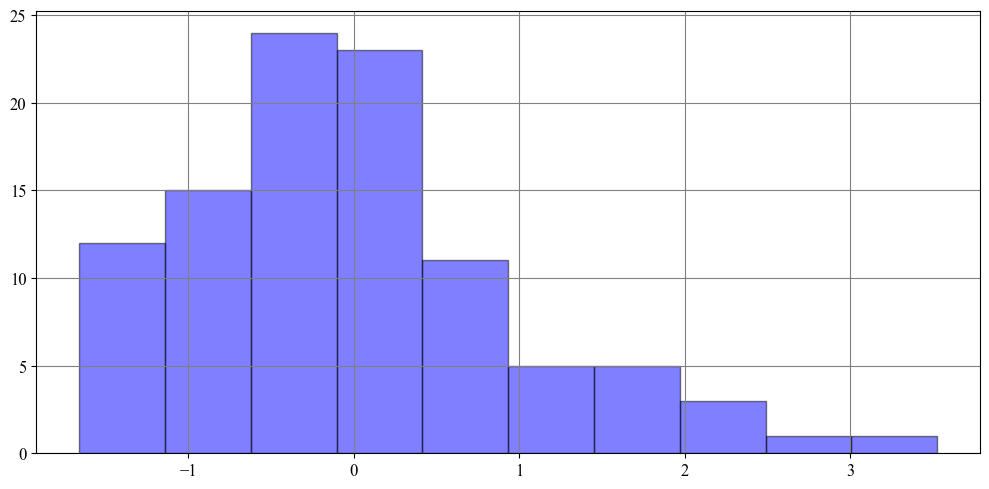

In [ ]:
counts, bin_edges, _ = plt.hist(z_scaled.T[0], bins=10, range=(min(z_scaled.T[0]), max(z_scaled.T[0])), histtype='barstacked', edgecolor='black', color='blue', alpha=0.5)

In [ ]:
print('Sample mean: ', z_scaled.mean())
print('Sample variance: ', z_scaled.std())

Sample mean:  -3.552713678800501e-17
Sample variance:  1.0


In [ ]:
z_extra_scaled = np.linspace(z_scaled.min(), z_scaled.max() + 5, 100).reshape(-1, 1)
mu_pred, std_pred = GPR.predict(z_extra_scaled, return_std=True)

In [ ]:
n_samples = 10

In [ ]:
samples = GPR.sample_y(z_extra_scaled, n_samples=n_samples, random_state=42)

In [ ]:
z_extra_original = z_scaler.inverse_transform(z_extra_sorted.reshape(-1, 1)).ravel()
mu_pred_original = mu_scaler.inverse_transform(mu_pred_sorted.reshape(-1, 1)).ravel()
std_pred_original = std_pred_sorted * mu_scaler.scale_[0]  # std scales linearly with scale factor

samples_original = mu_scaler.inverse_transform(samples_sorted.T).T  # transpose trick to inverse transform


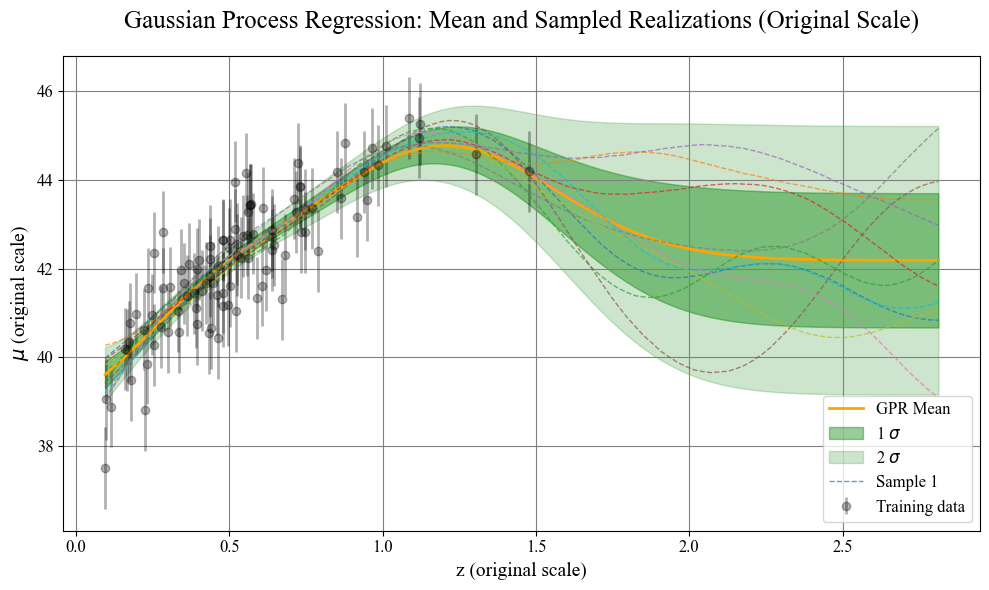

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(z_scaler.inverse_transform(z_scaled.T[0].reshape(-1,1)).ravel(),
             mu_scaler.inverse_transform(mu_scaled.T[0].reshape(-1,1)).ravel(),
             dmu_scaled.T[0] * mu_scaler.scale_[0],  # scale error bars back
             fmt='o', c='black', label='Training data', alpha=0.3)

plt.plot(z_extra_original, mu_pred_original, c='orange', label='GPR Mean')
plt.fill_between(z_extra_original,
                 mu_pred_original - std_pred_original,
                 mu_pred_original + std_pred_original,
                 alpha=0.4, color='green', label=r'1 $\sigma$')
plt.fill_between(z_extra_original,
                 mu_pred_original - 2*std_pred_original,
                 mu_pred_original + 2*std_pred_original,
                 alpha=0.2, color='green', label=r'2 $\sigma$')

for i in range(n_samples):
    plt.plot(z_extra_original, samples_original[:, i], lw=1, linestyle='--', alpha=0.7, label=f'Sample {i+1}' if i < 1 else None)

plt.xlabel("z (original scale)")
plt.ylabel(r"$\mu$ (original scale)")
plt.title("Gaussian Process Regression: Mean and Sampled Realizations (Original Scale)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()